# Caso Práctico de Módulo 3: Implementación de un Sistema de Recomendación de películas: MovieLens


* En este Notebook vamos a implementar y evaluar un ***Sistema de Recomendación basado en Filtrado Colaborativo con KNN*** usando la base de datos de [MovieLens 100K](https://grouplens.org/datasets/movielens/).


* Esta base de datos contiene 100.000 votos con notas de 1 a 5 de 943 usuarios sobre 1682 películas.


* Este dataset ha sido dividido en votaciones de entrenamiento (80%) y votaciones de test (20%). Además para simplificar el problema, los códigos de usuarios e items, han sido modificados para que comience en 0 y terminen en el número de (usuarios / items) - 1.


* Para ***implementar y evaluar este Sistema de Recomendación*** realizaremos los siguientes paso:
<span></span><br>
    1. [Lectura del Dataset (Entrenamiento y Test)](#M1)
<span></span><br>
    2. [Cálculo de similaridades](#M2)
<span></span><br>
    3. [Cálculo de los K-Vecinos](#M3)
<span></span><br>
    4. [Cálculo de las Predicciones](#M4)
<span></span><br>
    5. [Cálculo de las recomendaciones(*)](#M5)
<span></span><br>
    6. [Evaluación del Sistema de Recomendación (MAE)](#M6)
<span></span><br>
    7. [Sistema de Recomendación y Evaluación](#M7)


##### (*): El punto del cálculo de las Recomendaciones no lo vamos a realizar ya que este punto no es relevante de cara a evaluar el sistema de recomendación implementado.


In [ ]:
!pip install mxnet
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.7/111.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.2 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.3
    Uninstalling scipy-1.11.3:
      Successfully uninstalled scipy-1.11.3
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:


In [ ]:
import os
import pandas as pd
from mxnet import gluon, np
from d2l import mxnet as d2l

In [ ]:
d2l.DATA_HUB['ml-100k'] = (
    'https://files.grouplens.org/datasets/movielens/ml-100k.zip',
    'cd4dcac4241c8a4ad7badc7ca635da8a69dddb83')

def read_data_ml100k():
    data_dir = d2l.download_extract('ml-100k')
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'u.data'), sep='\t',
                       names=names, engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items


In [ ]:
data, num_users, num_items = read_data_ml100k()
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head(5))


number of users: 943, number of items: 1682
matrix sparsity: 0.936953
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


In [ ]:
data

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


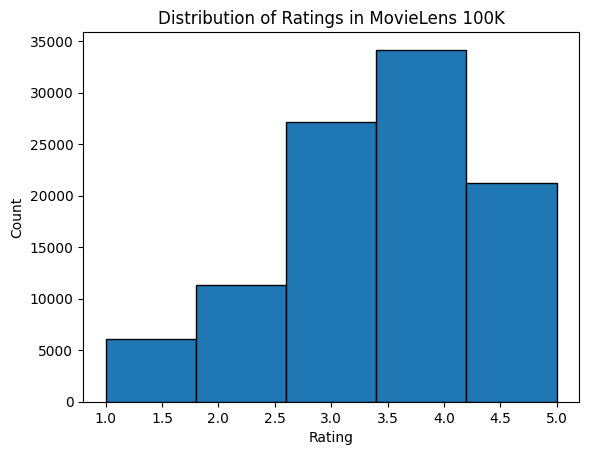

In [ ]:
d2l.plt.hist(data['rating'], bins=5, ec='black')
d2l.plt.xlabel('Rating')
d2l.plt.ylabel('Count')
d2l.plt.title('Distribution of Ratings in MovieLens 100K')
d2l.plt.show()

In [ ]:
def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):

    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

In [ ]:
train,test=split_data_ml100k(data,num_users,num_items)

In [ ]:
train

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


<hr>


# <a name="M1">1.- Lectura del Dataset (Entrenamiento y Test)
    
    
* A continuación implementamos una función que data la ruta donde se encuentra un fichero con la estructura "ID_USER::ID_MOVIE::RATING" nos devuelva una matriz de votos:

In [ ]:
def read_ratings_matrix(file):

    ratings = [[None for _ in range(NUM_ITEMS)] for _ in range(NUM_USERS)]

    with open(file, 'r') as reader:
        for line in reader:
            [u, i, rating] = line.split("::")
            ratings[int(u)][int(i)] = int(rating)

    return ratings

<hr>


# <a name="M2"> 2.- Cálculo de *Similaridades*


* A continuación implementamos una función que dada una matriz de votos y una métrica de similaridad, nos devuelva una matriz de similaridades entre cada par de usuarios.


* Tambien implemantamos las métricas de similaridad de:
    + MSD
    + Coseno
    + Correlación de Pearson
    + JMSD

In [ ]:
def calculate_similarities(ratings_matrix, similarity_metric):

    # Creamos una matriz con valores de similaridad a -1
    similarities = [[float('-inf') for _ in range(NUM_USERS)] for _ in range(NUM_USERS)]

    # Recorremos la matriz por usuario
    for i, u in enumerate(ratings_matrix):
        if i%100==0:
            print("\tProcesandos {} Usuarios".format(i))
        for j, v in enumerate(ratings_matrix):
            if j != i: # No calculamos la similaridad para un mismo usuario
                similarities[i][j] = similarity_metric(u,v)

    return similarities


def rating_average(ratings):

    acc = 0
    count = 0
    for id_item in range(len(ratings)):
        if ratings[id_item] != None:
            acc += ratings[id_item]
            count += 1
    return acc / count


def msd_similarity(u, v):

    sum_r = 0
    count = 0

    for i in range(len(u)):
        if u[i] != None and v[i] != None:
            count += 1
            sum_r += math.pow((u[i] - v[i])/(MAX_RATING - MIN_RATING), 2)

    if count > 0:
        sim = 1-(sum_r/float(count))
        return sim
    else:
        return None


def cosine_similarity(u, v):

    numerador = 0
    denominador_u = 0
    denominador_v = 0

    count = 0

    for i in range(len(u)):
        if u[i] != None and v[i] != None:
            numerador += u[i] * v[i]
            denominador_u += math.pow(u[i], 2)
            denominador_v += math.pow(v[i], 2)
            count += 1
    if count > 0 and denominador_u != 0 and denominador_v != 0:
        cos = numerador / (math.sqrt(denominador_u) * math.sqrt(denominador_v))
        return cos
    else:
        return None


def jmsd_similarity(u, v):

    union = 0
    intersection = 0

    for i in range(len(u)):
        if u[i] != None and v[i] != None:
            intersection += 1
            union += 1
        elif u[i] != None or v[i] != None:
            union += 1

    if intersection > 0:
        jaccard = intersection / union
        return jaccard * msd_similarity(u,v)
    else:
        return None


<hr>


# <a name="M3"> 3.- Cálculo de los *K-Vecinos*
    
    
* A continuación implementamos una función que dada una matriz de similaridades entre usuarios y un valor de 'K' (número de vecinos a calcular), nos devuelva una matriz de "NUM_USERS x K_VECINOS" indicando los vecinos de cada usuario:

In [ ]:
def calculate_neighbors(similarities_matrix, k_neighbors):

    neighbors = [None for _ in range(NUM_USERS)]

    for index, similarities in enumerate(similarities_matrix):
        i_neighbors = [i[0] for i in sorted(enumerate(similarities),
                                            key=lambda x:float('-inf') if x[1] is None else x[1],
                                            reverse=True)]
        neighbors[index] = i_neighbors[0:k_neighbors]

    return neighbors

<hr>


# <a name="M4"> 4.- Cálculo de las *Predicciones*
    
    
* A continuación implementamos un método que nos calcule las predicciones de los votos que emitirian los usuarios sobre los items con el método de agregación de "Media Ponderada":

In [ ]:
def calculate_weighted_average_prediction(ratings_matrix, similarities_matrix, neighbors):

    # Creamos una matriz para el cálculo de predicciones
    predictions = [[None for _ in range(NUM_ITEMS)] for _ in range(NUM_USERS)]

    # Recorremos la matriz de votos
    for i, u in enumerate(ratings_matrix):
        for j, v in enumerate(ratings_matrix[0]):
            # Obtenemos las similaridades con cada vecino y si voto
            numerador = 0
            denominador = 0
            for neighbor in neighbors[i]:
                if ratings_matrix[neighbor][j] != None:
                    numerador += similarities_matrix[i][neighbor] * ratings_matrix[neighbor][j]
                    denominador += similarities_matrix[i][neighbor]

            predictions[i][j] = None if denominador == 0 else numerador/denominador

    return predictions


<hr>


# <a name="M6"> 6.- Evaluación del Sistema de Recomendación (MAE)
    
    
* A continuación se implementa un método que dada la matriz de votos y la matriz de predicciones nos devuelve el MAE del Sistema de Recomendación:

In [ ]:
def get_mae(ratings_matrix, predictions_matrix):

    mae_users = [None for _ in ratings_matrix]

    # Recorremos la matriz de votos
    for i, u in enumerate(ratings_matrix):
        # Calculamos el MAE de cada usuario
        sum_user = 0
        count = 0
        for j, v in enumerate(ratings_matrix[0]):
            if ratings_matrix[i][j] != None and predictions_matrix[i][j] != None:
                sum_user += abs(ratings_matrix[i][j] - predictions_matrix[i][j])
                count += 1
        mae_users[i] = sum_user/count if count > 0 else None

    return np.nanmean(np.array(mae_users, dtype=np.float), axis=0)

<hr>


# <a name="M7">7.- Sistema de Recomendación y Evaluación
    
    
* A continuación se implementa el "Sistema de Recomendación", en el cual:
    + Calcularemos las similaridades para distintas métricas de similaridad
    + Realizaremos las predicciones para diferentes números de vecinos
    + Evaluaremos para cada experimento los conjuntos de entrenamiento y test.

In [ ]:
import math
import numpy as np
import pandas as pd

# Número de usuarios e items
NUM_USERS = 943
NUM_ITEMS = 1682

# Notas máximas y mínimas dadas en la matriz de votos
MIN_RATING = 1
MAX_RATING = 5

# Ruta del los datasets de entrenamiento y test
#TRAIN_RATINGS_FILE = '/content/drive/MyDrive/Aprendizaje/Practica5/Ejercicio4/movielens-100k-train.txt'
#TEST_RATINGS_FILE = '/content/drive/MyDrive/Aprendizaje/Practica5/Ejercicio4/movielens-100k-test.txt'

# Lectura de los Datasets de Entrenamiento y Test
train_ratings = train
test_ratings = test

# Metricas, K vecinos y predicciones a probar
SIMILARITIES_METRICS = [('MSD', msd_similarity),
                        ('COSENO', cosine_similarity),
                        ('JMSD', jmsd_similarity)]
K_NEIGHBORS = [25, 50, 100, 150, 200, 300, 400, 500]


# Guardo en una lista los experimentos realizados, siendo un experimento una lista con 4 posiciones:
#     1.- Métrica de similaridad
#     2.- Número de vecinos
#     3.- MAE
#     4.- Entrenamiento o Test
experiments = []

for metric in SIMILARITIES_METRICS:
    print('{}: Cálculo de similatidades'.format(metric[0]))
    similarities_matrix = None # TODO: llamar al método calculate_similarities
    for k in K_NEIGHBORS:

        print('  {} Vecinos'.format(k))
        neighbors_matrix = None # TODO: llamar al método calculate_neighbors

        # Calculamos las predicciones
        predictions = None # TODO: llamar al método calculate_weighted_average_prediction

        # Calculamos el MAE para entrenamiento y test
        mae_train = 0.0 # TODO: llamar al método get_mae
        mae_test = 0.0 # TODO: llamar al método get_mae

        # Añadimos los experimentos a la lista
        experiments.append([metric[0], k, mae_train, "Train"])
        experiments.append([metric[0], k, mae_test, "Test"])


In [ ]:
# Pasamos los resultados de los experimentos a un DataFrame
df_results = pd.DataFrame.from_records(experiments,
                                       columns=['Metrica', 'K-Vecinos', 'MAE', 'Train/Test'])


In [ ]:
pd.pivot_table(df_results[df_results['Train/Test']=='Train'],
               values=['MAE'],
               index=['K-Vecinos'],
               columns=['Metrica'])

MAE          
Metrica   COSENO JMSD  MSD
K-Vecinos                 
25           0.0  0.0  0.0
50           0.0  0.0  0.0
100          0.0  0.0  0.0
150          0.0  0.0  0.0
200          0.0  0.0  0.0
300          0.0  0.0  0.0
400          0.0  0.0  0.0
500          0.0  0.0  0.0

In [ ]:
pd.pivot_table(df_results[df_results['Train/Test']=='Test'],
               values=['MAE'],
               index=['K-Vecinos'],
               columns=['Metrica'])

MAE          
Metrica   COSENO JMSD  MSD
K-Vecinos                 
25           0.0  0.0  0.0
50           0.0  0.0  0.0
100          0.0  0.0  0.0
150          0.0  0.0  0.0
200          0.0  0.0  0.0
300          0.0  0.0  0.0
400          0.0  0.0  0.0
500          0.0  0.0  0.0

<ipython-input-23-5b1574cfdf14>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


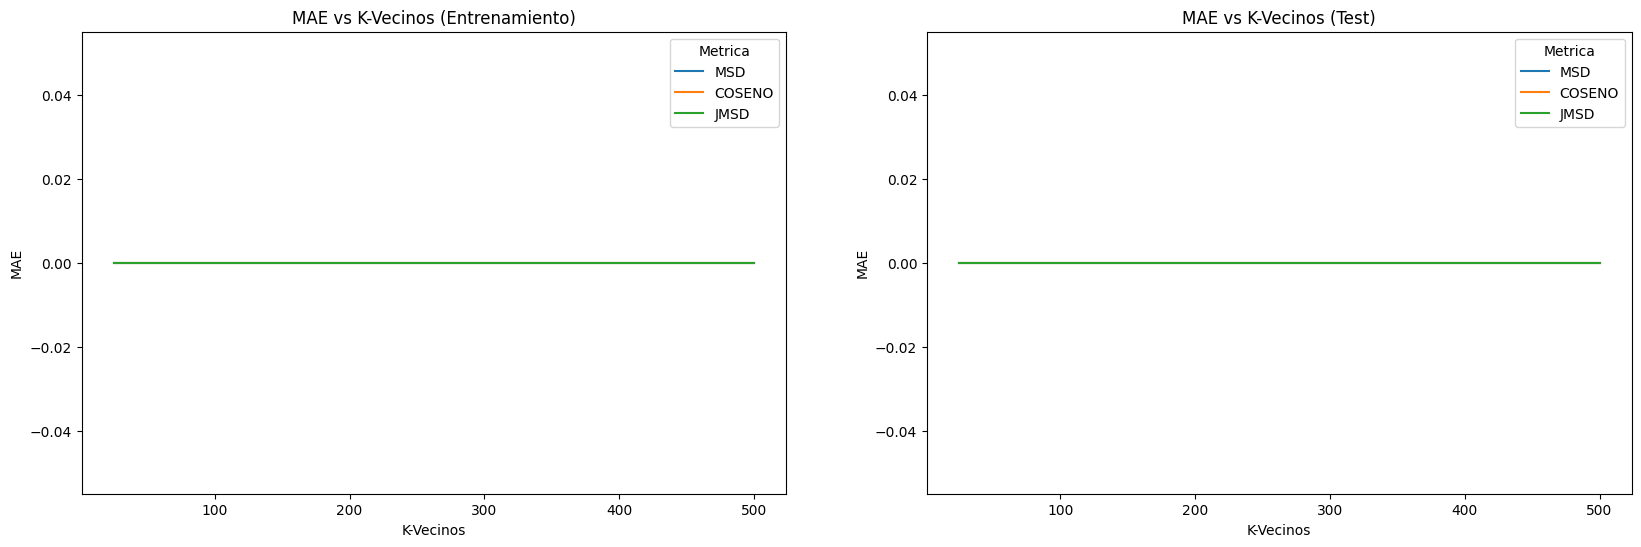

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize = (20, 6))
# Pintamos el MAE con los datos de Entrenamiento
plt.subplot(1, 2, 1)
plt.title('MAE vs K-Vecinos (Entrenamiento)')
sns.lineplot(x="K-Vecinos", y="MAE", hue="Metrica", data=df_results[df_results['Train/Test']=='Train'])

# Pintamos el MAE con los datos de Test
plt.subplot(1, 2, 2)
plt.title('MAE vs K-Vecinos (Test)')
sns.lineplot(x="K-Vecinos", y="MAE", hue="Metrica", data=df_results[df_results['Train/Test']=='Test'])

plt.show()